# Battle of neighborhoods

### Introduction/Business Problem

New York is metropolitan area with over 8 millions residents and with over 65 millions visitors per year. It is a great place for restaurant business. As expected, New York is one of the greatest food cities in the world. There is such diversity of cuisines, like no where else. If you can imagine of food, New York probably has it. 

John is a businessman and he wants to invest in a fine restaurant in Manhattan. He wants an analyse of neighborhoods and restaurants in this prosperous spot. The main goal is to make suggestion of the place and the type of a restaurant with the highest chance of success.

![Manhattan](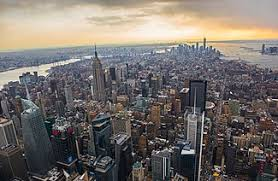 "Manhattan")



### Data

<ul>Obtaining the data
<li>For solving this problem we will need data from this URL: https://geo.nyu.edu/catalog/nyu_2451_34572. This data contain names of neighborhoods in New York and its longitudes and latitudes.</li>
<li>During inquiry, we will use data obtained via FourSquare API.</li>

> The search request in Foursquare API returns a list of venues near the current location in a JSON file, which will be converted into the dataframe.
    
<dl>Response fields are:
    <dt>id</dt><dd>A unique string identifier for this venue,</dd>
    <dt>name</dt>
    <dd>The best known name for this venue,</dd>
    <dt>location</dt>
    <dd>An object containing none, some, or all of address (street address), crossStreet, city, state, postalCode, country, lat, lng, and distance. All fields are strings, except for lat, lng, and distance. Distance is measured in meters. Some venues have their locations intentionally hidden for privacy reasons (such as private residences). If this is the case, the parameter isFuzzed will be set to true, and the lat/lng parameters will have reduced precision,</dd>
    <dt>categories</dt>
    <dd>An array, possibly empty, of categories that have been applied to this venue. One of the categories will have a primary field indicating that it is the primary category for the venue. </dd>
</dl>
</ul>
  

Analyzing the data, we will find Top 10 desirable locations for restaurant opening and, by clustering neighborhoods on similarity in restaurants we will recommend both the location and the type of restaurant with the highest chance of success - finding the neighborhood in a cluster which is similar to others, but having differencies in distribution of restaurant types.


### Methodology

> In this section we will:
<ul>
    <li> download the data and convert it to dataframe; </li>
    <li> use folium to display Manhattan and its neighborhoods; </li>
    <li> retrieve the data from FourSquare and clean it. We are interested only in restaurants, so we will use only that types of venueses;</li>
    <li> manipulate the data for getting Top 10 neighborhoods and the list of the most popular types of restaurants; </li>
    <li> visualize number of restaurants in Top 10 Neighborhhods</li>
    <li> find the best k for K-means algorithm</li>
    <li> use K-means algotithm for clustering the neighborhoods by there similarity/disimilarity of restaurants distribution. </li>
    
</ul>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


> Downloading data and converting it to dataframe

In [2]:
import requests

url = 'https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json'
data = requests.get(url).json()

In [3]:
newyork_data = data
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


> Selecting Manhattan Neighborhoods

In [4]:
# selecting Manhattan neighborhoods
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


> Creating map of Manhattan in folium using latitude and longitude values

In [5]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [6]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

> Getting data via FourSquare API

In [7]:
CLIENT_ID = 'IYR3Z23GZFCU4PF5PBZGTO4DSBA25FOJCMZ2PVP5PXA2E3IZ' # your Foursquare ID
CLIENT_SECRET = '5XIAY4XSOABZTBGZCNSNR22ECJUSOXB4CYGJWGIHT4F2UVAR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYR3Z23GZFCU4PF5PBZGTO4DSBA25FOJCMZ2PVP5PXA2E3IZ
CLIENT_SECRET:5XIAY4XSOABZTBGZCNSNR22ECJUSOXB4CYGJWGIHT4F2UVAR


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [10]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soba

In [11]:
# Selecting different types of restaurants among all the venues
restaurant_cols = [col for col in manhattan_onehot.columns if 'Restaurant' in col]

In [12]:
print('There are ', len(restaurant_cols), 'different types of restaurants in Manhattan!')

There are  76 different types of restaurants in Manhattan!


> Forming dataframe with restaurants venues only!

In [13]:
# forming dataframe with restaurants venues only!
restaurant_cols=['Neighborhood']+restaurant_cols
manhattan_restaurants=manhattan_onehot[restaurant_cols]

In [14]:
# Grouping by the Neighborhood
neighborhood_restaurants = manhattan_restaurants.groupby('Neighborhood').sum().reset_index()

In [15]:
neighborhood_restaurants.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Battery Park City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Carnegie Hill,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,2,0,3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,2
2,Central Harlem,0,3,2,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,Chelsea,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,3,0,0,2,1,1,0,0,0,1,0,0,8,0,0,2,2,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,1,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,3


> Sorting Neighborhoods by its total number of restaurans!

In [16]:
# Adding a new column with the total number of restaurants
neighborhood_restaurants.loc[:,'Total'] = neighborhood_restaurants.sum(axis=1)

In [17]:
# Sorting the table by 'Total' column
neighborhood_restaurants.sort_values(by=['Total'], inplace=True, ascending=False)
neighborhood_restaurants.reset_index(drop=True, inplace=True)
neighborhood_restaurants.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,Chinatown,0,0,3,0,0,2,1,1,0,0,0,1,0,0,8,0,0,2,2,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0,1,0,0,0,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,3,40
1,Noho,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,5,0,4,0,1,0,0,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,2,0,0,0,0,2,0,0,0,2,36
2,Little Italy,0,0,0,0,0,1,1,0,0,0,0,0,0,0,5,2,0,1,0,0,1,0,0,0,1,0,0,2,0,0,0,1,0,0,3,0,2,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,3,1,0,1,1,34
3,East Village,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,1,0,3,0,1,0,0,0,0,0,3,1,0,0,1,1,0,0,0,0,3,0,0,1,2,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2,3,33
4,Yorkville,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,7,0,3,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,1,0,0,2,29


> Plot of Top 10 Neighborhoods with the highest number of restaurants

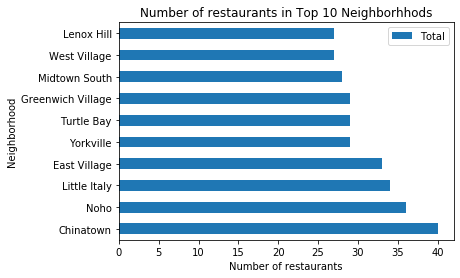

In [18]:
import matplotlib.pyplot as plt

df_for_plotting=  neighborhood_restaurants[['Neighborhood','Total']]
df_for_plotting=df_for_plotting.iloc[0:10,:]
df_for_plotting.set_index('Neighborhood', inplace=True)
df_for_plotting.plot(kind='barh')
plt.title('Number of restaurants in Top 10 Neighborhhods')
plt.xlabel('Number of restaurants')
plt.ylabel('Neighborhood')
plt.show()

> Forming a list with popular restaurants

In [19]:
neighborhood_restaurants.loc['Total_type',:]= neighborhood_restaurants.sum(axis=0)

In [20]:
df_neigh_rest=neighborhood_restaurants.drop('Neighborhood', axis=1, inplace=False)
# Selecting types of restaurant wich are very popular
average_number_of_restaurants = df_neigh_rest['Total'].sum() / len(df_neigh_rest.columns)
popular_restaurants =[]
for col in df_neigh_rest.columns:
        if df_neigh_rest.loc['Total_type'][col]>=average_number_of_restaurants:
            popular_restaurants = popular_restaurants + [col]
print(average_number_of_restaurants)

20.571428571428573


In [21]:
popular_restaurants.remove('Total')
print('Popular types of restaurants are: ')
print(popular_restaurants)

Popular types of restaurants are: 
['American Restaurant', 'Chinese Restaurant', 'French Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Restaurant', 'Seafood Restaurant', 'Sushi Restaurant', 'Thai Restaurant']


In [22]:

neigh_rest2 = manhattan_restaurants.groupby('Neighborhood').mean().reset_index()
neigh_rest2.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.015873,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.015873,0.015873,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.00000
1,Carnegie Hill,0.0,0.000000,0.011905,0.0,0.011905,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.011905,0.0,0.023810,0.0,0.00,0.0,0.00,0.0,0.0,0.02381,0.0,0.035714,0.0,0.00,0.011905,0.0,0.0,0.00,0.000000,0.011905,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.011905,0.011905,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.011905,0.0,0.0,0.00,0.000000,0.011905,0.0,0.0,0.011905,0.02381
2,Central Harlem,0.0,0.066667,0.044444,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.022222,0.0,0.044444,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.022222,0.0,0.000000,0.0,0.044444,0.0,0.00,0.0,0.00,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.022222,0.0,0.0,0.044444,0.00,0.0,0.0,0.0,0.022222,0.00,0.0,0.000000,0.0,0.0,0.00,0.022222,0.000000,0.0,0.0,0.000000,0.00000
3,Chelsea,0.0,0.000000,0.030000,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.010000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.010000,0.0,0.00,0.0,0.00,0.0,0.0,0.02000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.010000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.010000,0.010000,0.0,0.0,0.020000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.00000
4,Chinatown,0.0,0.000000,0.030000,0.0,0.000000,0.02,0.01,0.01,0.0,0.0,0.0,0.01,0.000000,0.0,0.080000,0.0,0.0,0.02,0.02,0.0,0.0,0.0,0.01,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.02,0.0,0.01,0.0,0.0,0.01000,0.0,0.000000,0.0,0.01,0.000000,0.0,0.0,0.02,0.000000,0.020000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.010000,0.01,0.0,0.0,0.0,0.000000,0.01,0.0,0.000000,0.0,0.0,0.01,0.000000,0.010000,0.0,0.0,0.010000,0.03000


> Forming dataframe with the Neighborhoods and its 5 the most common venues 

In [23]:
num_top_venues = 5

for hood in neigh_rest2['Neighborhood']:
    print("----"+hood+"----")
    temp = neigh_rest2[neigh_rest2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                      venue  freq
0  Mediterranean Restaurant  0.02
1        Mexican Restaurant  0.02
2        Chinese Restaurant  0.02
3         Afghan Restaurant  0.00
4   North Indian Restaurant  0.00


----Carnegie Hill----
                    venue  freq
0     Japanese Restaurant  0.04
1   Vietnamese Restaurant  0.02
2       French Restaurant  0.02
3      Italian Restaurant  0.02
4  Argentinian Restaurant  0.01


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1   Chinese Restaurant  0.04
2  American Restaurant  0.04
3   Seafood Restaurant  0.04
4    French Restaurant  0.04


----Chelsea----
                 venue  freq
0  American Restaurant  0.03
1   Seafood Restaurant  0.02
2   Italian Restaurant  0.02
3     Ramen Restaurant  0.01
4    French Restaurant  0.01


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.08
1  Vietnamese Restaurant  0.03
2    American Restaurant  0.03
3     Mexican Resta

                 venue  freq
0   Italian Restaurant  0.07
1     Sushi Restaurant  0.04
2  Japanese Restaurant  0.03
3   Mexican Restaurant  0.03
4   Chinese Restaurant  0.02




In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neigh_rest2['Neighborhood']

for ind in np.arange(neigh_rest2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neigh_rest2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Chinese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,French Restaurant
1,Carnegie Hill,Japanese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Thai Restaurant
2,Central Harlem,African Restaurant,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant
3,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Ramen Restaurant
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Mexican Restaurant,Malay Restaurant


> Finding the best K for K-Means - Elbow method

In [26]:
manhattan_grouped_clustering = neigh_rest2.drop('Neighborhood', 1)

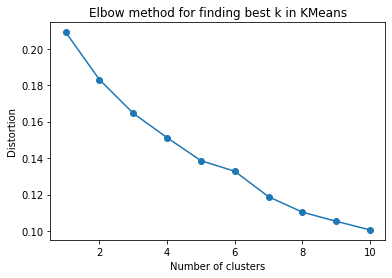

In [27]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(manhattan_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow method for finding best k in KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

> The best k = 5!

> Using K-means algotithm for clustering the neighborhoods by there similarity/disimilarity of restaurants distribution 

In [28]:
# set number of clusters
kclusters = 5

#manhattan_grouped_clustering = neigh_rest2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 1, 3, 1, 1, 2, 1, 1])

In [29]:
#iz manhattan data selektovati potrebne podatke
manh_data=neighborhoods_venues_sorted.join(manhattan_data.set_index('Neighborhood'),on='Neighborhood')
manh_data.drop('Borough', axis=1, inplace=True)
manh_data.insert(0,'Cluster Labels', kmeans.labels_)
manh_data.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude
0,1,Battery Park City,Chinese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,French Restaurant,40.711932,-74.016869
1,1,Carnegie Hill,Japanese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Thai Restaurant,40.782683,-73.953256
2,4,Central Harlem,African Restaurant,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant,40.815976,-73.943211
3,1,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Ramen Restaurant,40.744035,-74.003116
4,3,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Mexican Restaurant,Malay Restaurant,40.715618,-73.994279


### Result section

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manh_data['Latitude'], manh_data['Longitude'], manh_data['Neighborhood'], manh_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
manh_data.loc[manh_data['Cluster Labels'] == 0, manh_data.columns[[1] + list(range(2, manh_data.shape[1]-2))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Gramercy,Italian Restaurant,Mexican Restaurant,American Restaurant,Thai Restaurant,Sushi Restaurant
12,Greenwich Village,Italian Restaurant,Vietnamese Restaurant,Sushi Restaurant,Chinese Restaurant,Indian Restaurant
16,Lenox Hill,Italian Restaurant,Sushi Restaurant,Turkish Restaurant,Thai Restaurant,Mexican Restaurant
17,Lincoln Square,Italian Restaurant,American Restaurant,Mediterranean Restaurant,French Restaurant,Seafood Restaurant
21,Manhattanville,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Curry Restaurant
27,Noho,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Seafood Restaurant
29,Soho,Italian Restaurant,Mediterranean Restaurant,French Restaurant,Sushi Restaurant,Falafel Restaurant
31,Sutton Place,Italian Restaurant,Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Persian Restaurant
32,Tribeca,Italian Restaurant,American Restaurant,Greek Restaurant,French Restaurant,Korean Restaurant
34,Turtle Bay,Italian Restaurant,French Restaurant,Seafood Restaurant,Sushi Restaurant,Turkish Restaurant


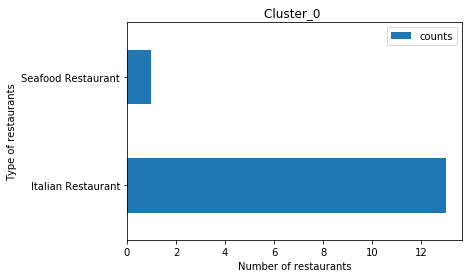

In [71]:
cl0=manh_data.loc[manh_data['Cluster Labels'] == 0, manh_data.columns[[2]]]
cl0_plot=cl0.groupby(['1st Most Common Venue']).size().reset_index(name='counts')
cl0_plot.set_index('1st Most Common Venue', inplace=True)
cl0_plot.plot(kind='barh')
plt.title('Cluster_0 ')
plt.xlabel('Number of restaurants')
plt.ylabel('Type of restaurants')
plt.show()

In [60]:
manh_data.loc[manh_data['Cluster Labels'] == 1, manh_data.columns[[1] + list(range(2, manh_data.shape[1]-2))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Chinese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vietnamese Restaurant,French Restaurant
1,Carnegie Hill,Japanese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,Thai Restaurant
3,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Ramen Restaurant
5,Civic Center,French Restaurant,American Restaurant,Sushi Restaurant,Vietnamese Restaurant,Cuban Restaurant
6,Clinton,American Restaurant,Italian Restaurant,New American Restaurant,Thai Restaurant,Brazilian Restaurant
8,East Village,Vietnamese Restaurant,Japanese Restaurant,Mexican Restaurant,Ramen Restaurant,Seafood Restaurant
9,Financial District,American Restaurant,Falafel Restaurant,Japanese Restaurant,Restaurant,French Restaurant
10,Flatiron,Italian Restaurant,American Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant
14,Hudson Yards,Italian Restaurant,American Restaurant,Restaurant,Caucasian Restaurant,Peruvian Restaurant
22,Marble Hill,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,Filipino Restaurant,Egyptian Restaurant


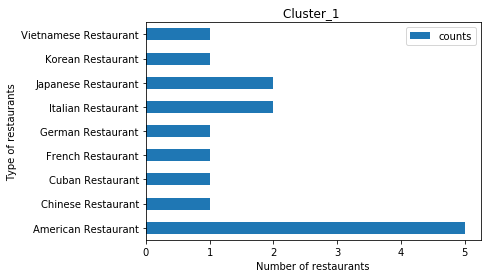

In [62]:
cl1=manh_data.loc[manh_data['Cluster Labels'] == 1, manh_data.columns[[2]]]
cl1_plot=cl1.groupby(['1st Most Common Venue']).size().reset_index(name='counts')
cl1_plot.set_index('1st Most Common Venue', inplace=True)
cl1_plot.plot(kind='barh')
plt.title('Cluster_1 ')
plt.xlabel('Number of restaurants')
plt.ylabel('Type of restaurants')
plt.show()

In [63]:
manh_data.loc[manh_data['Cluster Labels'] == 2, manh_data.columns[[1] + list(range(2, manh_data.shape[1]-2))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant,Cuban Restaurant,French Restaurant


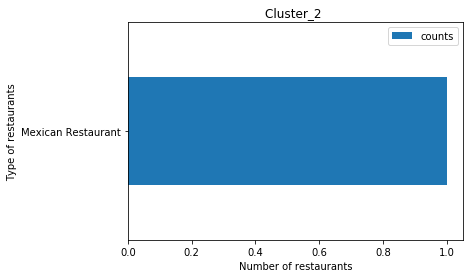

In [64]:
cl2=manh_data.loc[manh_data['Cluster Labels'] == 2, manh_data.columns[[2]]]
cl2_plot=cl2.groupby(['1st Most Common Venue']).size().reset_index(name='counts')
cl2_plot.set_index('1st Most Common Venue', inplace=True)
cl2_plot.plot(kind='barh')
plt.title('Cluster_2 ')
plt.xlabel('Number of restaurants')
plt.ylabel('Type of restaurants')
plt.show()

In [65]:
manh_data.loc[manh_data['Cluster Labels'] == 3, manh_data.columns[[1] + list(range(2, manh_data.shape[1]-2))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Mexican Restaurant,Malay Restaurant
13,Hamilton Heights,Mexican Restaurant,Caribbean Restaurant,Indian Restaurant,Sushi Restaurant,Chinese Restaurant
15,Inwood,Mexican Restaurant,Restaurant,Chinese Restaurant,Caribbean Restaurant,Spanish Restaurant
18,Little Italy,Chinese Restaurant,Mediterranean Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant
19,Lower East Side,Chinese Restaurant,Vietnamese Restaurant,French Restaurant,Italian Restaurant,American Restaurant
20,Manhattan Valley,Mexican Restaurant,Vietnamese Restaurant,Chinese Restaurant,Japanese Restaurant,American Restaurant
26,Murray Hill,Jewish Restaurant,Japanese Restaurant,Mediterranean Restaurant,Indian Restaurant,Cuban Restaurant
33,Tudor City,Mexican Restaurant,Vietnamese Restaurant,Asian Restaurant,Thai Restaurant,Greek Restaurant
37,Washington Heights,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Mexican Restaurant,Tapas Restaurant


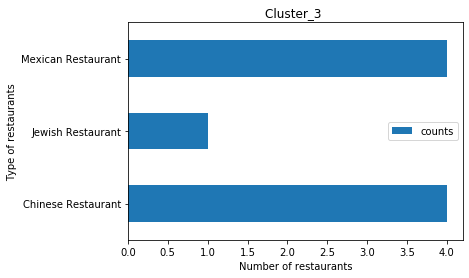

In [66]:
cl3=manh_data.loc[manh_data['Cluster Labels'] == 3, manh_data.columns[[2]]]
cl3_plot=cl3.groupby(['1st Most Common Venue']).size().reset_index(name='counts')
cl3_plot.set_index('1st Most Common Venue', inplace=True)
cl3_plot.plot(kind='barh')
plt.title('Cluster_3 ')
plt.xlabel('Number of restaurants')
plt.ylabel('Type of restaurants')
plt.show()

In [67]:
manh_data.loc[manh_data['Cluster Labels'] == 4, manh_data.columns[[1] + list(range(2, manh_data.shape[1]-2))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Central Harlem,African Restaurant,French Restaurant,American Restaurant,Chinese Restaurant,Seafood Restaurant


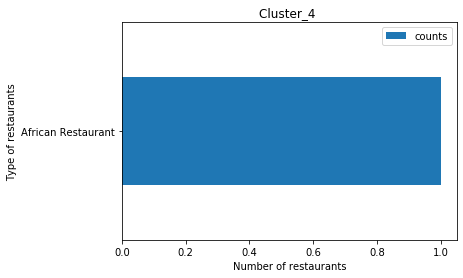

In [68]:
cl4=manh_data.loc[manh_data['Cluster Labels'] == 4, manh_data.columns[[2]]]
cl4_plot=cl4.groupby(['1st Most Common Venue']).size().reset_index(name='counts')
cl4_plot.set_index('1st Most Common Venue', inplace=True)
cl4_plot.plot(kind='barh')
plt.title('Cluster_4 ')
plt.xlabel('Number of restaurants')
plt.ylabel('Type of restaurants')
plt.show()

### Discussion

> The neighborhoods are clustered in 5 clusters based on there similarity/disimilarity of restaurats venues.The best invesment is in the best spots, so further disscussion will be made for the Top 10 Neighborhoods by the number of restaurants.

> In cluster0, there are two neighborhoods from the Top 10 list. These are Cinatown and Little Italy. Dominant type of restaurants is Chinese, so it is recommended to open a Chinese restaurant in these neighborhoods. If you want to avoid strong competition, you should invest in Italian restaurant given the its medium representation in these neighborhoods. It is the most frequent type of the restaurant in Manhattan, so there is no mistake. Italian Restorant is The second or The third most visited type of venuses, so there is space for spreading of this type of bussiness.

> In cluster1, there are 5 neighborhoods from the Top10 list of neighborhoods having the largest number of restaurants in Manhattan. These are: Lenox Hill, Greenwich Village, Turtle Bay, West Village and Yorkville. They are the great locations for open an Italian restaurants, because Italian restaurant is the most frequent type in these areas. On the second thaught, these areas are recommended for every single type of popular restaurants, determined prior in the notebook. There is great diversity of restaurants types, and these are areas known of big number of restaurants, so it could be success.

> In cluster2, there are 3 neighborhoods from the Top10 list. These are: Noho, Midtown South and East Village. The most popular types of restaurants are Vietnamese, Japanese Restaurant, Korean. The recommendation is to open a restaurant of these types.

> in clusters 3 and 4 there are no neighborhoods from Top 10, so we will not disccus them.

### Conclusion

> After all the analysis, we have deeper understanding of restaurant distribution in Manhattan, New York. However, it is not an easy task to make the final recommendation of the best location and the type of rastaurant to open. Further analysis are necessary  to make the final decision, but, sure we have some ideas!